In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import scipy.stats as stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

In [225]:
def fisher_p_value(rule):
    N = len(df)
    support_a_b = rule['support']
    support_a = rule['antecedent support']
    support_b = rule['consequent support']

    # Criando tabela de contingência
    a_and_b = support_a_b * N
    a_not_b = (support_a - support_a_b) * N
    not_a_b = (support_b - support_a_b) * N
    not_a_not_b = (1 - (support_a + support_b - support_a_b)) * N

    contingency_table = [[a_and_b, a_not_b], [not_a_b, not_a_not_b]]
    print(contingency_table)
    print('------')

    # Aplicando o teste de Fisher
    _, p_value = stats.fisher_exact(contingency_table)
    return p_value

def eclat(df, min_support):
    vertical_db = {item: set(df.index[df[item] == 1]) for item in df.columns}

    def recursive_eclat(prefix, items):
        results = []
        for i, (item, tids) in enumerate(items):
            new_prefix = prefix + [item]
            new_tids = tids
            support = len(new_tids)
            relative_support = support / len(df)

            if relative_support >= min_support:
                results.append((set(new_prefix), support, relative_support))
                new_items = [(other, other_tids & new_tids) for other, other_tids in items[i+1:] if len(other_tids & new_tids) >= min_support]
                results.extend(recursive_eclat(new_prefix, new_items))

        return results

    frequent_itemsets = recursive_eclat([], sorted(vertical_db.items(), key=lambda x: len(x[1]), reverse=True))

    return pd.DataFrame(frequent_itemsets, columns=["itemsets", "support (freq)", "support"])

def plot_association_rules_graph(df, binary_df, figsize=(12, 8)):
    df = df.sort_values(by="confidence", ascending=False)

    G = nx.DiGraph()

    support_values = df["support"].values
    confidence_values = df["confidence"].values
    edge_widths = 3

    all_labels = {}
    all_dashed_edges = []
    edge_labels = {}  # Dictionary to hold support labels for solid edges

    # Get the min and max lift values for normalization
    min_lift = df["lift"].min()
    max_lift = df["lift"].max()

    # Normalize lift values using Matplotlib's Normalize
    lift_norm = mcolors.Normalize(vmin=min_lift, vmax=max_lift)

    # Get the min and max support values for normalization (for node size)
    min_support = df["support"].min()
    max_support = df["support"].max()
    support_norm = mcolors.Normalize(vmin=min_support, vmax=max_support)

    # Color map for solid edges (based on lift)
    solid_edge_cmap = plt.cm.RdYlGn

    # Color map for dashed edges (based on antecedent support)
    dashed_edge_cmap = plt.cm.Blues  # Different color map for dashed edges

    for _, row in df.iterrows():
        antecedent = row["antecedents"]
        consequent = row["consequents"]
        lift = row["lift"]  # Directly use the lift value from the DataFrame

        # Split sets into individual nodes and add edges
        antecedent_nodes = list(antecedent)
        consequent_nodes = list(consequent)

        # Add the nodes to the graph with support calculated from the binary_df
        for node in antecedent_nodes + consequent_nodes:
            if node not in G.nodes:
                # Calculate the support from the binary_df
                node_support = binary_df[node].mean()  # Support is the mean of the binary values (frequency of 1s)
                G.add_node(node, support=node_support, antecedent=row["antecedent support"], consequent=row["consequent support"])

            # Add node label with its support value
            if node in G.nodes:
                node_support = G.nodes[node]["support"]  # Directly access the support value
                all_labels[node] = f"{node}\nS: {node_support*100:.1f}%"

        # Determine the color based on the normalized lift value (for solid edges)
        edge_color = solid_edge_cmap(lift_norm(lift))  # Normalize lift to color scale

        # If antecedent or consequent has multiple items, handle dashed edges
        if len(antecedent_nodes) > 1 or len(consequent_nodes) > 1:
            # Define dashed edges for multiple items, with support based on antecedent support
            for a in antecedent_nodes:
                for c in consequent_nodes:
                    all_dashed_edges.append((a, c))  # Add edge to dashed list
        else:
            # Otherwise, add a solid edge with normal support
            for a in antecedent_nodes:
                for c in consequent_nodes:
                    G.add_edge(a, c, weight=row["antecedent support"], confidence=row["confidence"], lift=lift, color=edge_color)
                    # Store support labels for solid edges
                    edge_labels[(a, c)] = f"C: {row['confidence']*100:.1f}%"  # Add support as label for solid edges

    # Get weakly connected components (instead of strongly connected)
    connected_components = list(nx.weakly_connected_components(G))

    # Plot each connected component separately
    for i, component in enumerate(connected_components):
        if len(component) > 1:  # Only plot components with more than 1 node
            # Create a subgraph for the component
            subgraph = G.subgraph(component)

            # Node positions using spring layout for the subgraph (not the entire graph)
            pos = nx.spring_layout(subgraph, seed=42)

            # Initialize labels for the subgraph (filtering to include only nodes in the component)
            subgraph_labels = {node: all_labels[node] for node in component}

            # Filter dashed edges to only include edges in the subgraph
            subgraph_dashed_edges = [(u, v) for u, v in all_dashed_edges if u in component and v in component]

            plt.figure(figsize=figsize)

            # Compute node sizes based only on the subgraph's nodes (based on support)
            node_sizes = [
                100 + 10 * (support_norm(G.nodes[node]["support"]) - min_support) / (max_support - min_support)
                for node in subgraph.nodes()
            ]

            # Draw nodes with sizes based on support
            nx.draw_networkx_nodes(subgraph, pos, node_color="lightgray", node_size=node_sizes)

            # Draw solid edges with color based on lift (no change in edge width)
            solid_edges = [e for e in subgraph.edges() if (e[0], e[1]) not in subgraph_dashed_edges]
            edge_colors = [subgraph[u][v]["color"] for u, v in solid_edges]
            nx.draw_networkx_edges(subgraph, pos, edgelist=solid_edges, edge_color=edge_colors, width=3, arrows=True, arrowsize=20)

            # Draw dashed edges for multi-item sets and include support label for each dashed edge
            dashed_edge_labels = {}
            dashed_edge_colors = []
            for u, v in subgraph_dashed_edges:
                dashed_support = len(binary_df[(binary_df[u]) & (binary_df[v])])/len(binary_df)
                dashed_edge_labels[(u, v)] = f"S: {dashed_support*100:.1f}%"  # Add support as label
                # Assign a different color map for dashed edges (based on antecedent support)
                dashed_edge_colors.append(dashed_edge_cmap(support_norm(dashed_support)))  # Different color map for dashed edges
            nx.draw_networkx_edges(subgraph, pos, edgelist=[(u, v) for u, v in subgraph_dashed_edges], edge_color=dashed_edge_colors, width=3, style="dashed", arrows=True, arrowsize=20)

            # Draw edge labels for dashed edges with support value
            nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=dashed_edge_labels, font_size=8, font_color="black")

            # Draw edge labels for solid edges with support value
            # Ensure that only edges present in the subgraph are labeled
            edge_labels_filtered = {k: v for k, v in edge_labels.items() if k[0] in component and k[1] in component}
            nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels_filtered, font_size=8, font_color="black")

            # Draw node labels with support values
            nx.draw_networkx_labels(subgraph, pos, labels=subgraph_labels, font_size=8, font_color="black")

            # Colorbar for true lift values (not normalized)
            sm = cm.ScalarMappable(cmap="RdYlGn", norm=lift_norm)  # Use normalized color scale
            sm.set_array([])  # Empty array for the colorbar
            cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.03, pad=0.02)
            cbar.set_label("Lift", fontsize=12)
            cbar.set_ticks([min_lift, (min_lift + max_lift) / 2, max_lift])  # Set ticks to reflect the true lift range

            plt.title(f"Association Rules Network Graph (Component {i + 1})", fontsize=14)
            plt.show()

In [ ]:
df = pd.read_csv('data/trabalho4_dados_4.csv')
df = df.astype(bool)
df

In [ ]:
itemsets = apriori(df, min_support=0.01, use_colnames=True)
itemsets

total de itemsets encontrados: 115
Mediana de suporte para itemsets: 0.027382943143812708
75% maiores suportes: 0.040551839464882944
90% maiores suportes: 0.06400501672240806
95% maiores suportes: 0.09456521739130434


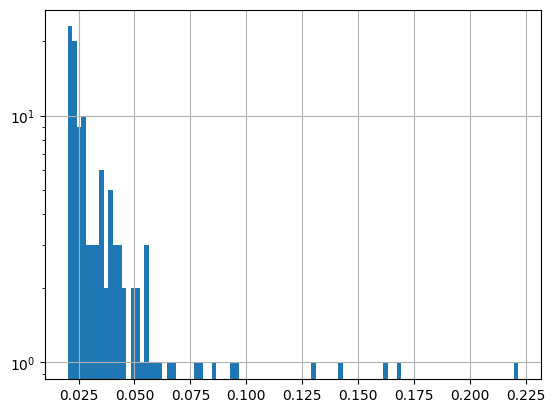

In [240]:
print(f"total de itemsets encontrados: {len(itemsets)}")
print(f"Mediana de suporte para itemsets: {itemsets['support'].median()}")
print(f"75% maiores suportes: {itemsets['support'].quantile(0.75)}")
print(f"90% maiores suportes: {itemsets['support'].quantile(0.90)}")
print(f"95% maiores suportes: {itemsets['support'].quantile(0.95)}")
itemsets['support'].hist(bins=100)
plt.yscale('log')

In [ ]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.01)
regras.sort_values(by="lift", ascending=False)
regras  

total de regras encontradas: 33
Mediana de confiaça para regras: 0.4444444444444445
75% maiores confianças: 0.5340314136125655
90% maiores confianças: 0.644705136334813
95% maiores confianças: 0.8109917355371901


<Axes: >

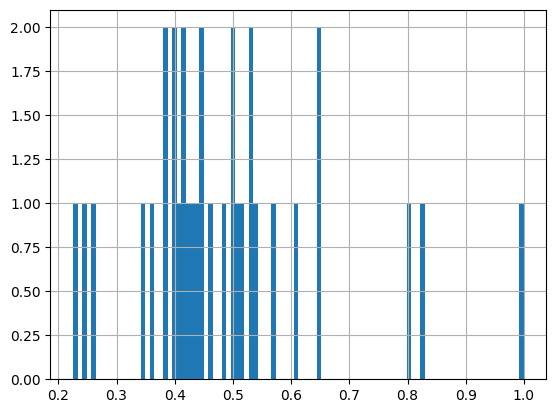

In [241]:
print(f"total de regras encontradas: {len(regras)}")
print(f"Mediana de confiaça para regras: {regras['confidence'].median()}")
print(f"75% maiores confianças: {regras['confidence'].quantile(0.75)}")
print(f"90% maiores confianças: {regras['confidence'].quantile(0.90)}")
print(f"95% maiores confianças: {regras['confidence'].quantile(0.95)}")
regras['confidence'].hist(bins=100)
# plt.yscale('log')

In [ ]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.5)
regras.sort_values(by="lift", ascending=False)
regras['p-value'] = regras.apply(fisher_p_value, axis=1)
regras  

In [238]:
itemsets = eclat(df, min_support=0.02)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.2)
regras = regras[(regras['confidence']*regras['support'] >= 0.01) & (regras['lift'] >= 1.1)]
regras.sort_values(by="confidence", ascending=False)
regras['p-value'] = regras.apply(fisher_p_value, axis=1)
regras

[[212.0, 598.0], [849.0, 3125.0]]
------
[[194.0, 586.9999999999999], [867.0, 3136.0]]
------
[[239.0, 386.99999999999994], [822.0, 3336.0000000000005]]
------
[[239.0, 822.0], [386.99999999999994, 3336.0000000000005]]
------
[[142.0, 265.0], [919.0, 3458.0]]
------
[[186.0, 264.0], [624.0, 3710.0]]
------
[[107.0, 58.99999999999999], [703.0, 3914.9999999999995]]
------
[[97.0, 72.99999999999999], [283.0, 4331.0]]
------
[[97.0, 24.0], [586.9999999999999, 4076.0]]
------
[[183.0, 275.0], [597.9999999999999, 3728.0]]
------
[[142.0, 228.0], [638.9999999999999, 3775.0]]
------
[[150.0, 176.99999999999997], [630.9999999999999, 3826.0000000000005]]
------
[[131.0, 165.00000000000003], [650.0, 3838.0]]
------
[[111.99999999999999, 149.0], [668.9999999999999, 3854.0]]
------
[[106.0, 106.0], [675.0, 3897.0]]
------
[[103.0, 88.00000000000001], [678.0, 3915.0000000000005]]
------
[[245.0, 135.0], [438.9999999999999, 3965.0]]
------
[[245.0, 438.9999999999999], [135.0, 3965.0]]
------
[[128.0,

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,p-value
0,(PAES),(BISCOITO),0.169314,0.221781,0.044314,0.261728,1.180121,1.0,0.006764,1.054109,0.183739,0.127788,0.051332,0.230770,3.433225e-03
1,(LEGUMES),(BISCOITO),0.163253,0.221781,0.040552,0.248399,1.120022,1.0,0.004346,1.035416,0.128068,0.117718,0.034204,0.215623,5.335856e-02
3,(SUCO),(BISCOITO),0.130853,0.221781,0.049958,0.381789,1.721470,1.0,0.020938,1.258825,0.482198,0.165055,0.205608,0.303524,1.052715e-22
4,(BISCOITO),(SUCO),0.221781,0.130853,0.049958,0.225259,1.721470,1.0,0.020938,1.121855,0.538539,0.165055,0.108620,0.303524,1.052715e-22
7,(LEITE),(BISCOITO),0.085075,0.221781,0.029682,0.348894,1.573149,1.0,0.010814,1.195227,0.398210,0.107089,0.163339,0.241365,1.006185e-09
20,(QUEIJOS),(PAES),0.094064,0.169314,0.038880,0.413333,2.441218,1.0,0.022953,1.415941,0.651666,0.173184,0.293756,0.321481,1.666535e-38
22,(MORTADELA),(PAES),0.034699,0.169314,0.022366,0.644578,3.806991,1.0,0.016491,2.337183,0.763829,0.123130,0.572135,0.388339,1.026463e-44
25,"(LEGUMES, PROD_LIMPEZA)",(LIMP_ROUPAS),0.035535,0.079431,0.020276,0.570588,7.183406,1.0,0.017453,2.143790,0.892506,0.214128,0.533536,0.412926,6.495071e-66
26,"(LEGUMES, LIMP_ROUPAS)",(PROD_LIMPEZA),0.025293,0.142977,0.020276,0.801653,5.606882,1.0,0.016660,4.320826,0.842969,0.137006,0.768563,0.471733,1.187068e-61
30,(FRUTAS),(LEGUMES),0.095736,0.163253,0.038253,0.399563,2.447517,1.0,0.022623,1.393565,0.654037,0.173295,0.282416,0.316939,4.775023e-38


In [ ]:
regras.columns

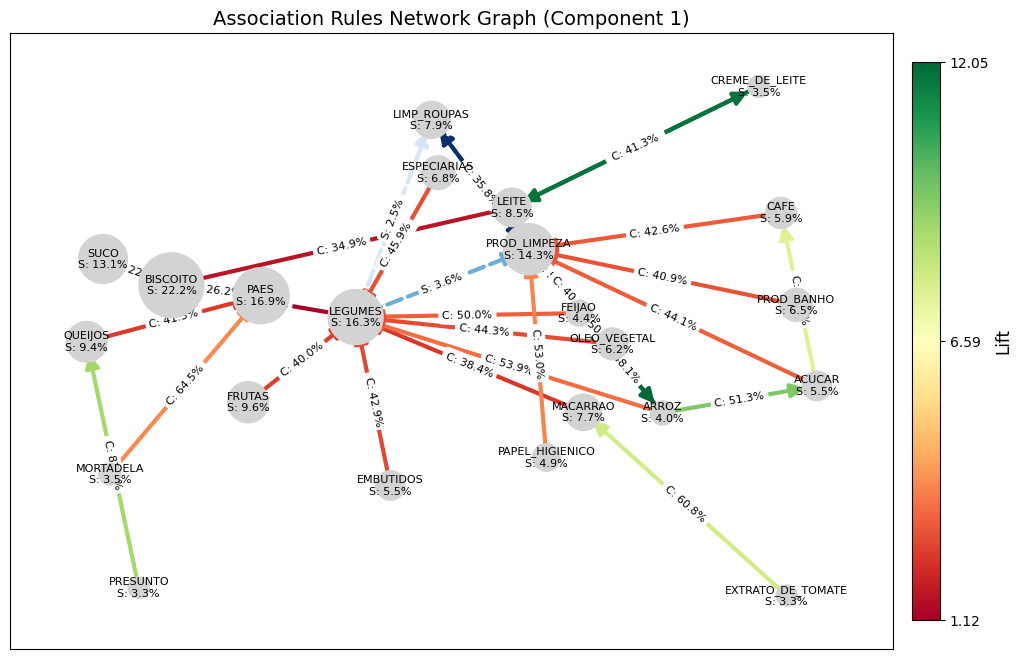

In [239]:
plot_association_rules_graph(regras, df)  # Pass both the df with rules and the binary DataFrame